In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
geo = "GSE70080"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Halvorsen2016", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [3]:
list(data.gsms.values())[20].metadata

{'title': ['lung 5'],
 'geo_accession': ['GSM1716799'],
 'status': ['Public on Oct 17 2016'],
 'submission_date': ['Jun 19 2015'],
 'last_update_date': ['Oct 17 2016'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['serum'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['disease state: lung'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['totRNA was exctracted from 500Âµl serum using miRCURY RNA isolation kit for biofluids'],
 'label_ch1': ['FAM'],
 'label_protocol_ch1': ['30ng totRNA was used for reverse transcription. Preamplification was performed following manufactors protocol PN4399721'],
 'hyb_protocol': ['n/a'],
 'scan_protocol': ['n/a'],
 'description': ['test'],
 'data_processing': ['Data was global normalized using ExpressionSuit software (v.1.0.3)(life technologies)',
  'The web-based software package automatically performs all deltadeltaCt based fold-change calculations from the uploaded raw threshold cycl

In [4]:
table = pd.concat((val.table.iloc[:,1:] for i,val in enumerate(data.gsms.values())), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [5]:
table

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
VALUE,-0.086,-2.085,-6.007,3.639,-2.782,-1.760,4.292,-1.220,NaN,3.740,...,-0.050,-1.290,-2.453,-3.313,-0.540,-2.535,-7.001,1.606,-4.125,-4.471
VALUE,1.018,-0.822,-5.546,2.447,-2.371,-2.375,6.413,-3.416,3.332,0.129,...,0.764,-1.001,0.505,-3.245,-3.460,0.587,-8.424,0.272,-3.178,-4.245
VALUE,NaN,0.976,-5.825,2.211,-1.764,-1.214,3.948,-2.406,1.297,1.123,...,1.821,-1.280,3.894,-3.790,-2.928,1.259,-7.345,-0.775,-1.741,-4.186
VALUE,NaN,-1.065,-4.751,3.080,-2.885,-3.239,2.489,-2.800,1.990,2.002,...,-0.533,-3.182,-1.049,-2.469,-2.862,-0.022,-6.438,0.198,-3.498,-3.456
VALUE,1.812,-2.752,-4.889,3.192,-3.381,-3.825,0.867,-3.253,0.759,0.527,...,0.014,-3.146,-1.297,-3.431,-3.977,-0.883,-7.687,-0.358,-3.891,-4.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,NaN,NaN,-2.328,NaN,-2.012,-1.437,NaN,-1.223,NaN,0.313,...,4.010,-2.256,-1.498,-1.365,-3.788,0.118,-7.083,1.794,-2.378,-2.358
VALUE,1.145,-2.733,-4.278,NaN,-2.200,-2.346,2.720,-1.154,NaN,2.345,...,0.588,-1.046,-0.605,-0.157,-1.067,NaN,-6.153,1.971,-0.990,-1.675
VALUE,1.738,-1.975,-4.457,2.894,-3.488,-3.926,0.865,-3.051,2.622,0.860,...,3.312,-2.469,-1.154,-1.339,-3.757,0.247,-5.837,0.143,-3.048,-2.335
VALUE,NaN,NaN,-2.641,4.693,-2.142,-1.725,NaN,-1.597,NaN,0.353,...,0.581,-2.877,-0.079,-0.870,-2.462,NaN,-7.227,4.120,-0.829,-2.072


### Seperate case and controls

In [6]:
sick = np.array(["lung" in k.metadata["title"][0] for k in list(data.gsms.values())[:-1]])
controls = np.array(["normal" in k.metadata["title"][0] for k in list(data.gsms.values())[:-1]])
mask = sick + controls
table = table.loc[mask]
sick = sick[mask]
controls = controls[mask]

In [7]:
sum(controls)

16

### Drop NAN

In [8]:
len(mirnas), len(table.columns)

(272, 272)

In [9]:
table = table.fillna(table.min().min())

In [10]:
table

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
VALUE,-21.168,3.711,-3.522,1.247,-1.312,-2.042,-21.168,-1.198,2.134,0.691,...,0.421,-1.947,4.096,3.019,-2.027,-0.364,-6.635,0.304,-0.090,-3.253
VALUE,-1.467,5.254,-7.578,-2.678,0.408,6.441,-21.168,-1.890,-3.544,0.948,...,-4.142,-1.145,1.522,-3.461,-2.886,2.570,-9.029,0.400,0.164,-5.291
VALUE,0.290,-21.168,-4.317,3.608,-1.082,0.442,-21.168,-0.072,1.948,1.253,...,0.969,-0.231,1.673,0.447,-1.466,-21.168,-6.750,1.377,-1.086,-4.428
VALUE,0.506,1.029,-5.808,-0.230,-1.293,-0.258,3.980,-2.058,-0.169,-0.035,...,-0.276,-0.866,3.719,-0.929,-3.050,0.628,-8.679,1.867,-0.027,-4.239
VALUE,-21.168,1.191,-4.973,1.392,-1.692,-2.236,-21.168,-1.159,-0.256,2.546,...,2.013,-2.186,1.482,1.033,-2.447,-0.820,-6.793,1.248,-2.718,-4.032
VALUE,-1.193,-0.187,-5.238,1.455,-0.505,2.477,-21.168,-0.652,2.612,1.880,...,0.280,-1.296,1.957,-0.382,-0.865,-21.168,-7.176,1.340,-0.331,-4.169
VALUE,1.548,0.663,-5.902,-0.751,-1.426,-0.214,5.457,-1.960,1.342,-0.085,...,-0.419,-2.284,4.110,-0.395,-2.568,5.292,-8.312,0.890,0.110,-4.451
VALUE,-21.168,-21.168,-3.300,1.849,-21.168,2.294,-21.168,0.346,-21.168,-21.168,...,-21.168,0.952,-21.168,2.062,1.739,-21.168,-3.328,-21.168,3.079,-2.094
VALUE,-21.168,-21.168,-2.996,-21.168,3.600,2.826,-21.168,-1.843,-21.168,-21.168,...,-21.168,-21.168,-21.168,0.927,0.000,-21.168,-4.696,1.894,3.971,-1.602
VALUE,-0.224,3.975,-5.481,-21.168,0.471,4.494,-21.168,-1.811,-21.168,0.865,...,1.738,0.514,3.253,-1.484,-0.782,-21.168,-7.541,0.366,2.115,-4.275


### T-test

In [11]:
X = table

In [12]:
X

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
VALUE,-21.168,3.711,-3.522,1.247,-1.312,-2.042,-21.168,-1.198,2.134,0.691,...,0.421,-1.947,4.096,3.019,-2.027,-0.364,-6.635,0.304,-0.090,-3.253
VALUE,-1.467,5.254,-7.578,-2.678,0.408,6.441,-21.168,-1.890,-3.544,0.948,...,-4.142,-1.145,1.522,-3.461,-2.886,2.570,-9.029,0.400,0.164,-5.291
VALUE,0.290,-21.168,-4.317,3.608,-1.082,0.442,-21.168,-0.072,1.948,1.253,...,0.969,-0.231,1.673,0.447,-1.466,-21.168,-6.750,1.377,-1.086,-4.428
VALUE,0.506,1.029,-5.808,-0.230,-1.293,-0.258,3.980,-2.058,-0.169,-0.035,...,-0.276,-0.866,3.719,-0.929,-3.050,0.628,-8.679,1.867,-0.027,-4.239
VALUE,-21.168,1.191,-4.973,1.392,-1.692,-2.236,-21.168,-1.159,-0.256,2.546,...,2.013,-2.186,1.482,1.033,-2.447,-0.820,-6.793,1.248,-2.718,-4.032
VALUE,-1.193,-0.187,-5.238,1.455,-0.505,2.477,-21.168,-0.652,2.612,1.880,...,0.280,-1.296,1.957,-0.382,-0.865,-21.168,-7.176,1.340,-0.331,-4.169
VALUE,1.548,0.663,-5.902,-0.751,-1.426,-0.214,5.457,-1.960,1.342,-0.085,...,-0.419,-2.284,4.110,-0.395,-2.568,5.292,-8.312,0.890,0.110,-4.451
VALUE,-21.168,-21.168,-3.300,1.849,-21.168,2.294,-21.168,0.346,-21.168,-21.168,...,-21.168,0.952,-21.168,2.062,1.739,-21.168,-3.328,-21.168,3.079,-2.094
VALUE,-21.168,-21.168,-2.996,-21.168,3.600,2.826,-21.168,-1.843,-21.168,-21.168,...,-21.168,-21.168,-21.168,0.927,0.000,-21.168,-4.696,1.894,3.971,-1.602
VALUE,-0.224,3.975,-5.481,-21.168,0.471,4.494,-21.168,-1.811,-21.168,0.865,...,1.738,0.514,3.253,-1.484,-0.782,-21.168,-7.541,0.366,2.115,-4.275


In [13]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [14]:
tvalues, results = ttest_ind(X_healthy, X_cancer).statistic, ttest_ind(X_healthy, X_cancer).pvalue

In [15]:
lowest, pvalues = np.argsort(results)[:20], np.sort(results)[:20]

In [16]:
[(mirnas.iloc[lowest[i]], tvalues[lowest[i]], pvalues[i]) for i in range(20)]

[('hsa-miR-20b-001014', 9.99463999903721, 1.0589511979285819e-13),
 ('hsa-miR-33b-002085', -8.677467264591911, 1.0994180465472254e-11),
 ('mmu-miR-93-001090', 8.028568345777979, 1.1474123490949722e-10),
 ('hsa-miR-425-5p-001516', 7.207108188336307, 2.313339576462312e-09),
 ('hsa-miR-501-001047', -7.007490336372019, 4.814294619090319e-09),
 ('hsa-miR-302a-000529', -6.842933486563722, 8.810086882680021e-09),
 ('hsa-miR-220b-002206', -5.963958999826626, 2.1949049076071393e-07),
 ('hsa-miR-205-000509', -5.823900199184666, 3.647681144019902e-07),
 ('hsa-miR-223-002295', 5.639525502280219, 7.097468249675409e-07),
 ('hsa-miR-122-002245', 5.4556778087783115, 1.3727795471894906e-06),
 ('hsa-miR-378-002243', 5.307916779289988, 2.3247396005818147e-06),
 ('hsa-miR-194-000493', -5.305406785148717, 2.3455672856461047e-06),
 ('hsa-miR-19b-000396', 5.268802664520508, 2.6710844844229767e-06),
 ('hsa-miR-627-001560', -5.0932325998739225, 4.966174698939251e-06),
 ('hsa-miR-574-3p-002349', 5.0901782410026

### F-test

In [17]:
t3 = table

In [18]:
f, p = f_classif(t3, sick)

In [19]:
np.mean(p)

0.3813422667997347

### ANOVA

In [20]:
t3

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
VALUE,-21.168,3.711,-3.522,1.247,-1.312,-2.042,-21.168,-1.198,2.134,0.691,...,0.421,-1.947,4.096,3.019,-2.027,-0.364,-6.635,0.304,-0.090,-3.253
VALUE,-1.467,5.254,-7.578,-2.678,0.408,6.441,-21.168,-1.890,-3.544,0.948,...,-4.142,-1.145,1.522,-3.461,-2.886,2.570,-9.029,0.400,0.164,-5.291
VALUE,0.290,-21.168,-4.317,3.608,-1.082,0.442,-21.168,-0.072,1.948,1.253,...,0.969,-0.231,1.673,0.447,-1.466,-21.168,-6.750,1.377,-1.086,-4.428
VALUE,0.506,1.029,-5.808,-0.230,-1.293,-0.258,3.980,-2.058,-0.169,-0.035,...,-0.276,-0.866,3.719,-0.929,-3.050,0.628,-8.679,1.867,-0.027,-4.239
VALUE,-21.168,1.191,-4.973,1.392,-1.692,-2.236,-21.168,-1.159,-0.256,2.546,...,2.013,-2.186,1.482,1.033,-2.447,-0.820,-6.793,1.248,-2.718,-4.032
VALUE,-1.193,-0.187,-5.238,1.455,-0.505,2.477,-21.168,-0.652,2.612,1.880,...,0.280,-1.296,1.957,-0.382,-0.865,-21.168,-7.176,1.340,-0.331,-4.169
VALUE,1.548,0.663,-5.902,-0.751,-1.426,-0.214,5.457,-1.960,1.342,-0.085,...,-0.419,-2.284,4.110,-0.395,-2.568,5.292,-8.312,0.890,0.110,-4.451
VALUE,-21.168,-21.168,-3.300,1.849,-21.168,2.294,-21.168,0.346,-21.168,-21.168,...,-21.168,0.952,-21.168,2.062,1.739,-21.168,-3.328,-21.168,3.079,-2.094
VALUE,-21.168,-21.168,-2.996,-21.168,3.600,2.826,-21.168,-1.843,-21.168,-21.168,...,-21.168,-21.168,-21.168,0.927,0.000,-21.168,-4.696,1.894,3.971,-1.602
VALUE,-0.224,3.975,-5.481,-21.168,0.471,4.494,-21.168,-1.811,-21.168,0.865,...,1.738,0.514,3.253,-1.484,-0.782,-21.168,-7.541,0.366,2.115,-4.275


In [21]:
X = np.array(sick).reshape(-1, 1)

In [22]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [23]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.0665968424662321

### Mean-variance-plot

In [24]:
np.mean(table)

0     -8.253500
1     -3.660185
2     -4.879370
3     -1.320056
4     -2.096352
         ...   
267   -7.500407
268   -7.370852
269   -0.836296
270   -2.130278
271   -3.625519
Length: 272, dtype: float64

In [25]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [26]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

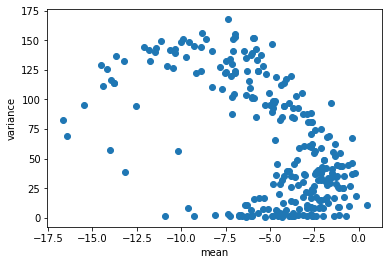

In [27]:
mean_variance_plot(table)

### Log transformation

In [28]:
log_table = table #np.log2(table)

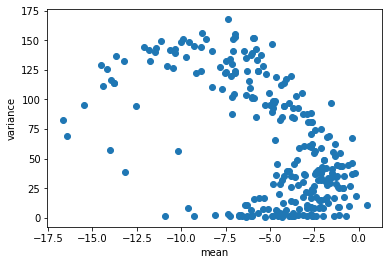

In [29]:
mean_variance_plot(log_table)

In [30]:
norm_log_table = log_table #- np.mean(log_table)

In [31]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

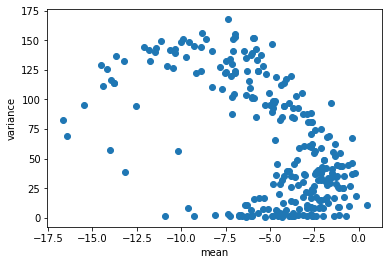

In [32]:
mean_variance_plot(norm_log_table)

### PCA

In [33]:
pca = decomposition.PCA(n_components=10)

In [34]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [35]:
pca.explained_variance_ratio_

array([0.2430666 , 0.06786523, 0.0481194 , 0.03494219, 0.03270095,
       0.03040642, 0.02762001, 0.02698591, 0.02512007, 0.02380709])

In [36]:
components = pca.transform(norm_log_table)

In [37]:
components.shape

(54, 10)

In [38]:
sum(controls)

16

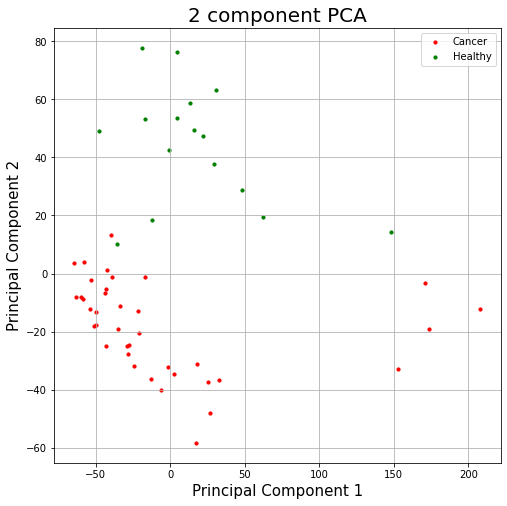

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [40]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

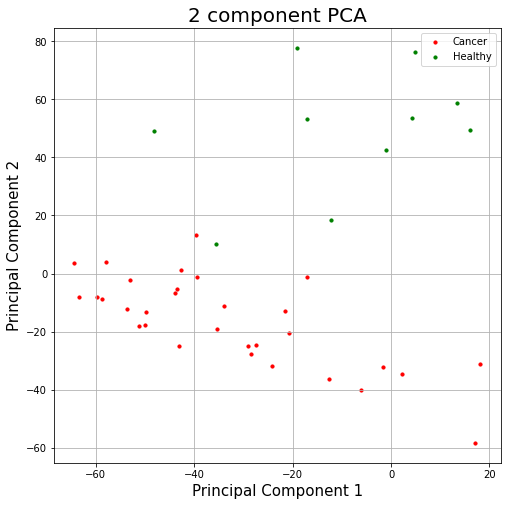

In [41]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [42]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


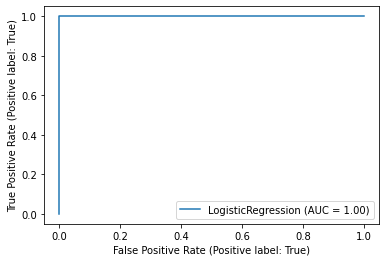

In [44]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [45]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


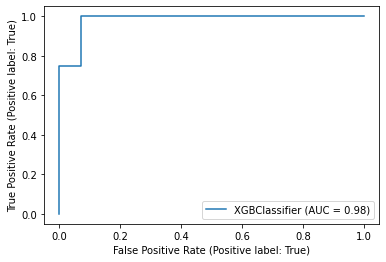

In [46]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [47]:
mask = np.array([True if m[:3] == "hsa" else False for m in mirnas])

In [48]:
len(mask), len(mirnas), len(norm_log_table.columns)

(272, 272, 272)

In [49]:
mirnas = mirnas[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [50]:
mirnas = [m[:-7] for m in mirnas]

In [51]:
mirnas = [m.replace("A", "a").replace("B", "b").replace("P", "p") for m in mirnas]

In [52]:
from Scripts import converters

In [53]:
sequences = converters.canonical_to_seq(mirnas, True)

In [54]:
sequences.count(None)

9

In [55]:
sequences = np.array(sequences)

In [56]:
mask = sequences != None

In [57]:
sequences = sequences[mask]
norm_log_table = norm_log_table.loc[:, mask]

In [58]:
sequences[:10]

array(['UGAGGUAGUAGGUUGUAUAGUU',
       'CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG',
       'GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC',
       'CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG',
       'CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG',
       'UGAGGUAGUAGAUUGUAUAGUU',
       'AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA',
       'UGGAAUGUAAAGAAGUAUGUAU', 'UACAGUACUGUGAUAACUGAA',
       'AAAAGUGCUUACAGUGCAGGUAG'], dtype=object)

In [59]:
norm_log_table.columns = sequences
#norm_log_table *= -1
norm_log_table["cancer"] = sick

In [60]:
norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC,CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG,CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG,UGAGGUAGUAGAUUGUAUAGUU,AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA,UGGAAUGUAAAGAAGUAUGUAU,UACAGUACUGUGAUAACUGAA,AAAAGUGCUUACAGUGCAGGUAG,...,CUGCCCUGGCCCGAGGGACCGA,UCCAUUACACUACCCUGCCUCU,UCUUUGGUUAUCUAGCUGUAUGA,UAUUGCACUUGUCCCGGCCUGU,UGGGGAGCUGAGGCUCUGGGGGUG,UCUUCUCUGUUUUGGCCAUGUG,UUCAACGGGUAUUUAUUGAGCA,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
VALUE,3.711,-3.522,1.247,-1.312,-2.042,-21.168,-1.198,2.134,0.691,-5.778,...,3.351,-4.593,2.601,-6.630,-21.168,1.727,1.118,0.421,-1.947,True
VALUE,5.254,-7.578,-2.678,0.408,6.441,-21.168,-1.890,-3.544,0.948,-8.136,...,0.000,-0.849,8.536,-5.490,-1.332,-3.970,-2.883,-4.142,-1.145,True
VALUE,-21.168,-4.317,3.608,-1.082,0.442,-21.168,-0.072,1.948,1.253,-5.963,...,1.118,-5.809,3.461,-6.867,-1.882,0.806,0.941,0.969,-0.231,True
VALUE,1.029,-5.808,-0.230,-1.293,-0.258,3.980,-2.058,-0.169,-0.035,-6.792,...,1.266,-3.432,4.064,-5.988,0.381,-0.883,0.164,-0.276,-0.866,True
VALUE,1.191,-4.973,1.392,-1.692,-2.236,-21.168,-1.159,-0.256,2.546,-6.560,...,3.605,-3.031,-21.168,-5.961,-21.168,0.544,-21.168,2.013,-2.186,True


In [61]:
norm_log_table.to_csv("../TransformedData/Halvorsen2016_raw.csv", index=False)